In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from typing import List, Tuple, Dict
import warnings

Connect to the dataset

In [3]:
db = sqlite3.connect("aosp_acs.db")

Queries

In [4]:
def cursor_to_dataframe(cursor):
    with warnings.catch_warnings():
        # TODO: pandas 2.1.0 has a FutureWarning for concatenating DataFrames with Null entries
        warnings.filterwarnings("ignore", category=FutureWarning)
        columns = [desc[0] for desc in (cursor.description)]
        df_records = pd.DataFrame(columns=columns)
        for row in cursor:
            df_temp = pd.DataFrame([row], columns=columns)
            if df_temp.empty:
                continue
            df_records = pd.concat([df_records, df_temp])
    return df_records.reset_index(drop=True)

In [5]:
def acs_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT count(id) as ac_count,path,ac,loc FROM ac_reports WHERE path IN (SELECT path FROM files WHERE files.project_name = ?) GROUP BY path,ac",(project_name,))
    return cursor_to_dataframe(cursor)

def ck_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT * from classes WHERE file_path IN (SELECT path FROM files WHERE files.project_name = ?)", (project_name,))
    df = cursor_to_dataframe(cursor)
    NUMERIC_FIELDS = ['cbo', 'cboModified', 'fanin',
       'fanout', 'wmc', 'dit', 'noc', 'rfc', 'lcom', 'lcom_normalized', 'tcc',
       'lcc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty',
       'privateMethodsQty', 'protectedMethodsQty', 'defaultMethodsQty',
       'visibleMethodsQty', 'abstractMethodsQty', 'finalMethodsQty',
       'synchronizedMethodsQty', 'totalFieldsQty', 'staticFieldsQty',
       'publicFieldsQty', 'privateFieldsQty', 'protectedFieldsQty',
       'defaultFieldsQty', 'finalFieldsQty', 'synchronizedFieldsQty', 'nosi',
       'loc', 'returnQty', 'loopQty', 'comparisonsQty', 'tryCatchQty',
       'parenthesizedExpsQty', 'stringLiteralsQty', 'numbersQty',
       'assignmentsQty', 'mathOperationsQty', 'variablesQty',
       'maxNestedBlocksQty', 'anonymousClassesQty', 'innerClassesQty',
       'lambdasQty', 'uniqueWordsQty', 'modifiers', 'logStatementsQty']
    for field in NUMERIC_FIELDS:
        df[field] = df[field].astype(float)
    return df


"""Prevalence report of AC in a project"""
def report_types_of_acs(project_name) -> dict:
    sql = f"SELECT ac, count(id) as qty FROM ac_reports WHERE project_name LIKE '{project_name}' GROUP BY ac ORDER BY qty DESC"
    cursor = db.execute(sql)
    return cursor_to_dataframe(cursor)

def files_in_a_project(project_name) -> pd.DataFrame:
    cursor = db.execute("SELECT * FROM files WHERE project_name = ?", (project_name,))
    return cursor_to_dataframe(cursor)

def loc_of_file(file_name) -> int:
    cursor = db.execute("SELECT loc FROM files WHERE path = ?", (file_name,))
    return int(next(cursor)[0])

def number_of_acs_in_files(project_name) -> dict:
    sql = f"""
    SELECT files.path, coalesce(ac_count, 0) AS count_acs
    FROM files
    LEFT JOIN
    (SELECT ac_reports.path AS ac_reports_path, count(id) AS ac_count
    FROM ac_reports
    WHERE project_name = '{project_name}'
    GROUP BY ac_reports.path)
    ON files.path = ac_reports_path
    WHERE files.project_name = '{project_name}'
    ORDER BY count_acs DESC;
    """
    cursor = db.execute(sql)
    return {k: v for k,v in cursor}

def report_files_with_acs(project_name) -> pd.Series:
    sql = f"SELECT DISTINCT path FROM ac_reports WHERE project_name = '{project_name}'"
    cursor = db.execute(sql)
    return pd.Series([tup[0] for tup in cursor])

def report_files_without_acs(project_name) -> pd.Series:
    sql = f"SELECT path FROM files WHERE project_name = '{project_name}'"
    cursor = db.execute(sql)
    all_files = [tup[0] for tup in cursor]
    files_with_ac = report_files_with_acs(project_name)
    return pd.Series([file for file in all_files if file not in files_with_ac])


In [6]:
def identity(x):
    return x

Get the list of core apps

In [7]:
cursor = db.execute("SELECT * FROM files WHERE path LIKE '/AOSP/packages/apps%';")
apps_set = set()
for path,loc, project_name in cursor:
    apps_set.add(project_name)

In [8]:
apps_data :Dict[str, Dict[str, pd.DataFrame]] = {}
for project in apps_set:
    apps_data[project] = {
        "ck": ck_in_a_project(project),
        "acs": acs_in_a_project(project),
        "files": files_in_a_project(project)
    }

print("Projects processed: ", len(apps_data.keys()))

Projects processed:  65


AVG, median, percentiles...

In [9]:
def process_ck(df: pd.DataFrame) -> pd.DataFrame:
    pd_recast_numeric = pd.DataFrame()
    output = pd.DataFrame()
    for col in df.columns:
        try:
            if col in ["id", "file_path"]:
                raise ValueError
            pd_recast_numeric[col] = pd.to_numeric(df[col])
            # output[f"{col}__mean"] = pd_recast_numeric[col].mean(skipna=True)
            # output[f"{col}__median"] = pd_recast_numeric[col].median(skipna=True)
            # output[f"{col}__90_perc"] = pd_recast_numeric[col].quantile(.90 )
        except ValueError:
            continue
        except Exception as e:
            print("Exception: ", e)
            print(f"Skipping column {col} of type {pd_recast_numeric[col].dtype}")
    return pd_recast_numeric.describe()

In [10]:
apps_data[project_name]["acs"].loc[apps_data[project_name]["acs"]["ac"] == "Logic as Control Flow"]["ac_count"].sum()

163

In [11]:
%%script echo skipping
def countacs(project_name: str) -> pd.DataFrame:
    loc_sum = apps_data[project_name]["files"]["loc"].sum()
    ac_count = apps_data[project_name]["acs"]["ac_count"].sum()
    loc_by_acs = loc_sum/ac_count if ac_count > 0 else -1
    return pd.DataFrame([(loc_sum, ac_count, loc_by_acs)], columns=["loc_sum", "ac_count", "loc_by_acs"])



df_apps_ac: pd.DataFrame = pd.DataFrame()
for idx, project_name in enumerate(apps_set):
    apps_ac_map = countacs(project_name)
    apps_ac_map = apps_ac_map.assign(project_name=[project_name])
    df_apps_ac = pd.concat([df_apps_ac, apps_ac_map])
df_apps_ac = df_apps_ac.reset_index(drop=True)

df_loc_by_acs = df_apps_ac.sort_values("loc_by_acs", ascending=True)

fig, ax = plt.subplots()


ax.bar(df_loc_by_acs["project_name"], df_loc_by_acs["loc_by_acs"], 0.9)
ax.figure.set_figwidth(12)
ax.figure.set_figheight(5)
ax.yaxis.set_label_text("Lines of code per AC")
ax.xaxis.set_label_text("Project Name")

plt.xticks(rotation=90)
plt.savefig("fig.png")


skipping


In [12]:
def plot_ac_report_bar(project_name):
    df_report = report_types_of_acs(project_name)
    df_report = df_report.assign(perc=(df_report["qty"] / df_report["qty"].sum()).astype(float).round(2))
    df_report = df_report.assign(label=df_report["ac"] + " " + df_report["perc"].astype(str))
    fig, ax = plt.subplots()
    ax.figure.set_figwidth(12)
    ax.figure.set_figheight(5)
    wedges, _ = ax.pie(df_report["perc"], wedgeprops=dict(width=0.5), startangle=0)

    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        Epsilon = .00001
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        if ang == 180:
            ang = 179
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(df_report["label"][i], xy=(x + Epsilon, y + Epsilon), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    ax.set_title(f"Prevalence of {project_name}")
    plt.savefig(f"imgs/prevalence_{project_name.replace('/', '_')}.png")
    plt.close()



In [13]:
%%script echo skipping
for project_name in apps_set:
    try:
        plot_ac_report_bar(project_name)
    except:
        print(f"Failed to render graph for {project_name}")

skipping


In [14]:
def correlation_with_loc(project_name):
    corr_test = acs_in_a_project(project_name).groupby("path").agg({"ac_count": "sum", "loc": "max"}).reset_index()
    corr_test["ac_count"] = corr_test["ac_count"].astype(int)
    corr_test["loc"] = corr_test["loc"].astype(int)
    return corr_test.corr("pearson", numeric_only=True)["ac_count"]["loc"]

def export_ac_cout_loc(project_name:str):
    df = acs_in_a_project(project_name).groupby("path").agg({"ac_count": "sum", "loc": "max"}).reset_index()
    escaped_project_name = project_name.replace("/","_")
    df.to_csv(f"./corrs/{escaped_project_name}.csv")

In [15]:
for proj in apps_set:
    export_ac_cout_loc(proj)

In [16]:
corrs = [(projname, correlation_with_loc(projname)) for projname in apps_set]

### CellBroadcastReceiver analysis

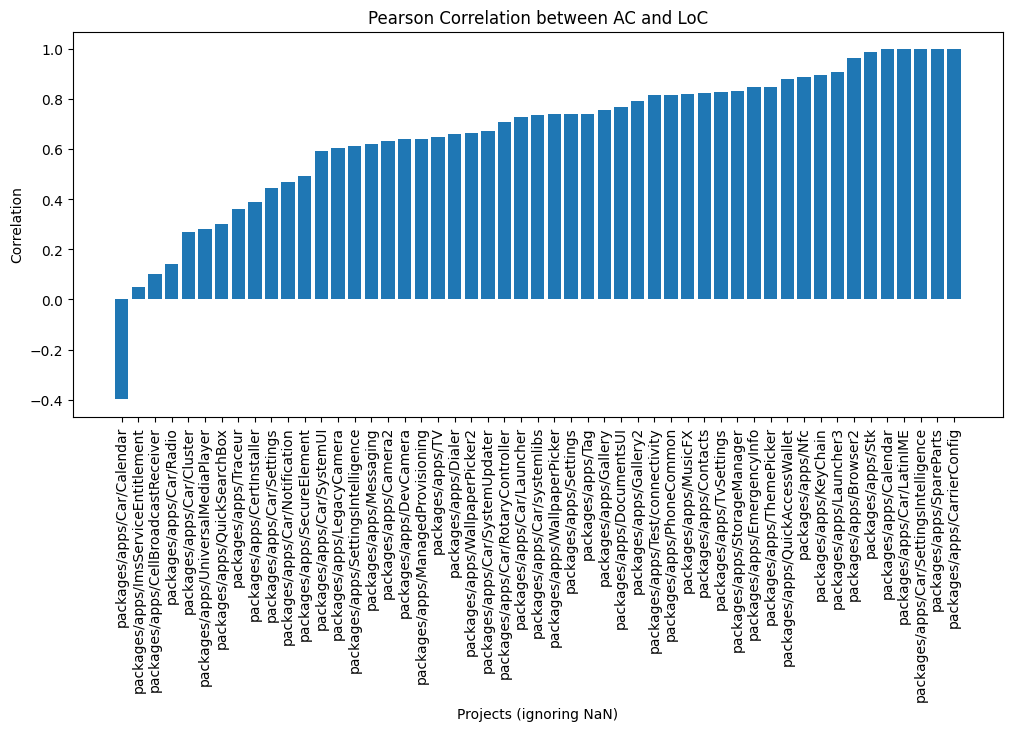

In [17]:
corrs = [c for c in corrs if not np.isnan(c[1])]
s = pd.DataFrame(np.array(corrs), columns=["project_name", "correlation"])
s["correlation"] = s["correlation"].astype(float)
s = s.sort_values(by="correlation")

fig, ax = plt.subplots()
ax.figure.set_figwidth(12)
ax.figure.set_figheight(5)
ax.bar(s["project_name"], s["correlation"])
ax.set_title("Pearson Correlation between AC and LoC")
ax.yaxis.set_label_text("Correlation")
ax.xaxis.set_label_text("Projects (ignoring NaN)")
plt.xticks(rotation=90)
plt.show()

## Filewise analysis

In [18]:
def ac_ck_pipeline(project_name: str):
    df_ck = ck_in_a_project(project_name).groupby("file_path").mean(numeric_only=True).reset_index()
    df_ck["file_path"] = df_ck["file_path"].astype("str")
    df_ck["path"] = df_ck["file_path"]
    df_files = files_in_a_project(project_name)[["path", "loc"]]
    df_files["path"] = df_files["path"].astype(str)
    df_ck.drop(columns=["loc"], inplace=True) # drop loc, use from files instead.

    pd_merged = pd.merge(df_files, df_ck, how="left", on="path")
    df_ac = acs_in_a_project(project_name)[["path", "ac_count"]].groupby("path").agg({"ac_count": "sum"}).reset_index()

    pd_merged = pd.merge(pd_merged, df_ac, how="left", on="path")
    pd_merged.infer_objects(copy=False)
    pd_merged["ac_count"] = pd_merged["ac_count"].astype(float).fillna(0).astype(int)
    pd_merged["loc"] = pd_merged["loc"].astype(int)
    pd_merged.drop(columns=["file_path"], inplace=True)
    return pd_merged


In [19]:
df_correlations = pd.DataFrame()
series = []
for i, project_name in enumerate(apps_set):
    serie = ac_ck_pipeline(project_name).corr(method="pearson", numeric_only=True)["ac_count"]
    serie["project_name"] = project_name
    series.append(serie)
df_correlations = pd.DataFrame.from_records(series)

df_correlations

,loc,cbo,cboModified,fanin,fanout,wmc,dit,noc,rfc,lcom,...,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,ac_count,project_name
0,0.650582,0.138902,0.221385,0.232486,0.138439,0.600985,0.108106,0.083780,0.332997,0.312033,...,0.315738,0.341247,0.250691,0.161154,0.216227,0.355932,0.025592,NaN,1.0,packages/apps/Settings
1,0.485437,0.107763,-0.002300,-0.128704,0.107763,0.508055,-0.172130,0.241718,0.234455,0.126255,...,0.505066,0.277556,0.007890,0.280785,0.286940,0.364876,0.145479,NaN,1.0,packages/apps/Car/Radio
2,0.357133,0.123152,0.091477,-0.031880,0.123152,0.271596,-0.153276,-0.033246,0.464470,0.298523,...,0.073913,0.121271,0.780749,-0.067425,NaN,-0.043583,-0.041168,NaN,1.0,packages/apps/QuickSearchBox
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,packages/apps/OnDeviceAppPrediction
4,0.696191,0.210999,0.175427,0.042850,0.210999,0.515764,-0.036230,-0.042141,0.415450,0.431481,...,0.581540,0.242885,0.163955,0.229313,0.150296,0.304346,-0.025795,-0.003103,1.0,packages/apps/TV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.589418,-0.033454,0.027427,0.145752,-0.033454,0.387217,-0.185267,0.035417,0.208154,0.331839,...,0.141165,0.222639,0.354098,0.359569,0.152339,0.206361,0.014864,NaN,1.0,packages/apps/Car/SystemUI
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,packages/apps/SampleLocationAttribution
62,0.908124,0.220142,0.183742,0.068382,0.215556,0.431063,-0.049619,-0.023373,0.320770,0.575980,...,0.376547,0.110690,0.323072,0.109686,0.080838,0.253394,0.002016,NaN,1.0,packages/apps/Launcher3
63,0.878194,0.581171,0.566692,0.033346,0.581171,0.823273,0.002453,-0.173831,0.640707,0.827605,...,0.752244,0.145999,0.633172,-0.035275,NaN,0.229218,-0.117678,NaN,1.0,packages/apps/PhoneCommon


In [20]:
df_correlations.to_csv("corr_per_project_mean.csv", index=False)

In [21]:
records = []
for app in apps_set:
    df_files = files_in_a_project(app)
    df_ac = acs_in_a_project(app)
    serie_files_with_ac = report_files_with_acs(app)
    records.append({
        "project_name": app,
        "file_qty": df_files.size,
        "loc_sum": df_files["loc"].sum(),
        "files_with_ac_perc": serie_files_with_ac.size / df_files.size
    })
df_metrics = pd.DataFrame.from_records(records)
df_metrics

,project_name,file_qty,loc_sum,files_with_ac_perc
0,packages/apps/Settings,13272,676097,0.115657
1,packages/apps/Car/Radio,108,5942,0.148148
2,packages/apps/QuickSearchBox,129,3854,0.046512
3,packages/apps/OnDeviceAppPrediction,3,268,0.333333
4,packages/apps/TV,2337,162178,0.143346
...,...,...,...,...
60,packages/apps/Car/SystemUI,780,46453,0.107692
61,packages/apps/SampleLocationAttribution,3,211,0.000000
62,packages/apps/Launcher3,2763,214758,0.191459
63,packages/apps/PhoneCommon,39,1695,0.128205


## Projectwise analysis

In [22]:
def ac_ck_pipeline_projectwise(project_name: str):
    df_merged = ac_ck_pipeline(project_name)
    df_merged.drop(columns=["path"], inplace=True)
    # Aggregation dict
    agg_methods = {k: "mean" for k in df_merged.columns if k not in ["path", "project_name"]}
    agg_methods["loc"] = "sum" # sum aggregation for LoC
    agg_methods["ac_count"] = "sum" # sum aggregation for ac count
    df_merged = df_merged.agg(agg_methods, numeric_only=True)
    df_merged["project_name"] = project_name

    # put project_name first
    columns = list(df_merged.index)
    columns.insert(0, columns.pop())
    df_merged = df_merged[columns]
    return df_merged

In [33]:
records: List[pd.Series] = []
for project_name in apps_set:
    records.append(ac_ck_pipeline_projectwise(project_name))
df_project_wise_analysis = pd.concat(records, axis=1).T
df_project_wise_analysis = df_project_wise_analysis.infer_objects()
for col in df_project_wise_analysis.columns:
    if col != "project_name":
        df_project_wise_analysis[col] = df_project_wise_analysis[col].astype(float)
df_project_wise_corr = df_project_wise_analysis.corr(method="pearson", numeric_only=True)
df_project_wise_corr["ac_count"].sort_values(ascending=False)

ac_count                  1.000000
loc                       0.928824
fanin                     0.352203
noc                       0.324988
finalMethodsQty           0.273965
protectedFieldsQty        0.237292
protectedMethodsQty       0.210124
publicMethodsQty          0.195348
cboModified               0.178057
visibleMethodsQty         0.175665
lcom                      0.164721
modifiers                 0.145390
publicFieldsQty           0.122904
totalMethodsQty           0.096204
returnQty                 0.094905
synchronizedMethodsQty    0.088726
staticMethodsQty          0.085735
fanout                    0.057087
cbo                       0.055133
lcom_normalized           0.028043
parenthesizedExpsQty      0.023738
nosi                      0.020946
wmc                       0.018405
comparisonsQty            0.011358
lambdasQty               -0.000493
innerClassesQty          -0.007684
uniqueWordsQty           -0.012256
totalFieldsQty           -0.013331
abstractMethodsQty  